Emily Wang and Filippos Lymperopoulos | Data Science 2016 | CYOA: sfcrime

Feb 17, 2016

### Goals for *model_iter_7_emily.ipynb*

* Improve readability
* Several different folds; summary statistics on k folds
* Different ideas for feature engineering/encoding

Note: Apologies if model_iter_7_emily.ipynb is a misleading title; the models themselves are similar to the models that have been happening since notebook 4 or 5, and have been using the same preprocessor class (SFP). What's different is the accompanying analysis and additional commentary from the previous model_iter_X notebooks.

Feb 15, 2016

### The process

* Import libraries and training data
* Feature engineering / preprocessing: 
    * Make "useful" combinations of features to give our model; 
    * Also encode categorical things in an intelligent way; 
    * Can choose to only use a subset of features if desired
* Partition your data (cross-validation kfolds, etc)
* Model fit
* Make some predictions
* Compute the logloss score
* Reflect; iterate 

Firstly, let's import some useful libraries and import the data. 

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from IPython.display import display
from sklearn.cross_validation import train_test_split
from sklearn import preprocessing
from sklearn import cross_validation
from sklearn.metrics import log_loss
import numpy as np
import pprint as pp

# Convert the Dates column of our provided data from string to datetime format.
train = pd.read_csv('train.csv', parse_dates = ['Dates'])
test = pd.read_csv('test.csv', parse_dates = ['Dates'])

# Print the first 3 rows of the dataframe.
display(train.head(3))

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y
0,2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
1,2015-05-13 23:53:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
2,2015-05-13 23:33:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",VANNESS AV / GREENWICH ST,-122.424363,37.800414


### Feature Engineering, Preprocessing

Make a class that will:
* Extract the time features we want to use for the model (e.g. year, season, month, day, etc.)
* Encode categorical variables in a meaningful way: contains a preprocessor that can both transform and inverse_transform the categorical variables
* Return a transformed dataframe to be given to the model
* Maybe: allow for some flexibility with what is in the transformed dataframe (to iterate quickly) (e.g. choosing how many time features you want in this experiment)

In [3]:
# SFP = SFCrime Preprocessor
class SFP():
    def __init__(self, data):
        self.data = data
        self.Y_encoder = preprocessing.LabelEncoder()
    
    # Prepare inputs
    def prep_district(self):
        # one hot encoding
        return pd.get_dummies(self.data.PdDistrict)
    
    def prep_hour(self):
        # a continuous value from 0 to 23
        return self.data.Dates.dt.hour # Gets the hour portion form the "Dates" column
    
    def prep_day(self):
        # one hot encoding
        return pd.get_dummies(self.data.DayOfWeek)
    
    def prep_years(self):
        # beware: 2015 has significantly less incidents than the other years in this dataset.        
        pass
    
    def concat_features(self):
        hour = self.prep_hour()
        day = self.prep_day()
        district = self.prep_district()
        return pd.concat([hour, day, district], axis=1)
    
    # Encode or decode classes
    def encode_Y(self, Y):
        return self.Y_encoder.fit_transform(Y)

    def decode_Y(self, encoded_Y):
        return self.Y_encoder.inverse_transform(encoded_Y)

In [4]:
sfp = SFP(train)
X = sfp.concat_features()
y = sfp.encode_Y(train.Category)
X.rename(columns = {'Dates':'Hour'}, inplace = True)

#### Sanity check

Print out the head for X to ensure that our preprocessing via the SFP class worked as expected. 
We should have a number between 0 and 39 for Hour. Each incident should have a 1 in one of the weekday columns and 0 in all other weekday columns. Each incident should have a 1 in one of the PdDistrict columns and 0 ina ll other PdDistrict columns. 

In [5]:
display(X.head())

,Hour,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,BAYVIEW,CENTRAL,INGLESIDE,MISSION,NORTHERN,PARK,RICHMOND,SOUTHERN,TARAVAL,TENDERLOIN
0,23,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0
1,23,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0
2,23,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0
3,23,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0
4,23,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0


### Partition the data!

In [6]:
# note: this X and Y in particular are from the data in train.csv. See previous section for details.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.40, random_state=42)

### Fit the training data to the algorithm

Decision trees are known to be good at handling categorical data. Let's try using some of the decision tree variations in scikit learn (decision tree, random forest, gradient boost, etc) and tweak some hyperparameters. We might even do some ensemble learning. Oooh shiny!

#### Decision Tree

In [7]:
from sklearn import tree
dtc = tree.DecisionTreeClassifier()
_ = dtc.fit(X_train, y_train)
y_predictions = dtc.predict_proba(X_test)
print y_predictions
dtc_log_loss = log_loss(y_test, y_predictions)

[[ 0.          0.099631    0.         ...,  0.02214022  0.099631
   0.01476015]
 [ 0.          0.05607477  0.         ...,  0.06542056  0.04672897
   0.00934579]
 [ 0.          0.06768838  0.         ...,  0.05491699  0.03320562
   0.00383142]
 ..., 
 [ 0.00179211  0.06989247  0.         ...,  0.01792115  0.03763441
   0.01612903]
 [ 0.00305344  0.07022901  0.         ...,  0.01984733  0.05954198
   0.01221374]
 [ 0.          0.06991525  0.         ...,  0.00847458  0.08474576
   0.00635593]]


In [8]:
dtc_log_loss 

3.007115993440352

Filippos says he thinks this log loss value of 3.007115993440352 is very deece. Confirmed by looking at the kaggle leaderboards.

#### A baseline: Predict all unseen incidents as LARCENY/THEFT

So... we know from the exploration phase that the dataset is not evenly distributed (i.e. not all 39 classes are equally represented in the dataset. What's the log loss for a model that just predicts that all new data is the most common crime type ('LARCENCY/THEFT') ? This means that the baseline model outputs the same prediction each time: a 39 dimensional vector of 0s and a 1 in the corresponding column for LARCENY/THEFT. The 1 signifies 100% confidence that the unseen incident is LARCENY/THEFT. 

Another idea for a baseline would be to randomly guess an intger between 0 and 38 for each unseen incident. 

Since log loss is a new error metric for us amd we don't already have an intuition for what log loss values are possible/reasonable for this project, this baseline provides a sanity check to ensure that we should be getting a better score on the models we are trying to train well with feature engineering, different classifiers, ensembling, etc.

In [9]:
decoded = sfp.decode_Y(dtc.classes_)

for x in range(len(decoded)):
    if decoded[x] == "LARCENY/THEFT": 
        # we know from the exploration phase that LARCENY/THEFT was the most popular crime in train.csv
        popular_index = x

baseline_y_pred = np.zeros((y_test.shape[0], 39))
baseline_y_pred[:,16] = 1

baseline_log_loss = log_loss(y_test, baseline_y_pred)

In [10]:
baseline_log_loss

27.658162800015461

#### Random Forest!!

In [11]:
from sklearn.ensemble import RandomForestClassifier

# Using some hyperparameter values from DataQuest mission 75
rf = RandomForestClassifier(random_state=1, n_estimators=10, min_samples_split=4, min_samples_leaf=1) 
_ = rf.fit(X_train, y_train)
y_predictions = rf.predict_proba(X_test)
rf_log_loss = log_loss(y_test, y_predictions)

In [12]:
rf_log_loss

3.0111558103212417

#### Stochastic Gradient Descent
[scikit learn cheatsheet advises us to look into SGD classifiers!](http://scikit-learn.org/stable/tutorial/machine_learning_map/)

Understanding SGD:
* yay Andrew Ng ML video
* batch gradient descent (looks at all of the training examples in every iteration)
* stochastic gradient descent (looks at only one training example in every iteration)
    * how well is my hypothesis doing on a single example? for a given theta and x,y pair
* different in the implementation details and making progress towards the minimum

In [13]:
from sklearn.linear_model import SGDClassifier
sgd = SGDClassifier(loss="log", penalty="l2", n_iter = 10)
_ = sgd.fit(X_train, y_train)
y_predictions = sgd.predict_proba(X_test)
sgd_log_loss = log_loss(y_test, y_predictions)

In [14]:
sgd_log_loss

2.6718009977038615

"Ooooooooooohhhh"  -- Emily and Filippos

#### Naive Bayes


In [15]:
from sklearn.naive_bayes import BernoulliNB
nb = BernoulliNB()
_ = nb.fit(X_train, y_train)
y_nb_predictions = nb.predict_proba(X_test)
nb_log_loss = log_loss(y_test, y_nb_predictions)

In [16]:
nb_log_loss

2.609770164645326

"Ooooooooooohhhh" (again)  -- Emily and Filippos

#### Next steps

ASAP:
* ~~prepare a submission to kaggle~~
* Visualization of performance of the different models (include an ensemble learning result in here too)
* ~~Comparison of log loss to the "predict the most common thing" baseline model (predict all unseen incidents to be LARCENY/THEFT)~~
* *10 fold validation + mean and standard deviation for the metrics* - Emily
* ~~log loss on each separate class (turn the multi class problem into 39 binary problems)~~
    * --> discover more specifically which things the model predicts well and not so well 
    * --> more exploration and feature engineering in hopes of resolving the difference in performance between crime classes


Backlog:
* ~~explanation on SGD black box~~
* ~~How to translate the 39-element outputs into more "human readable" outputs: TOP5~~
* *Creative approaches to ensemble learning!* - Filippos 
* ~~Naive Bayes~~
* Try playing with hyperparameters; see how changes in those values impact the logloss, and plot them (hyperparameter value vs. log loss)

Process comments:
* Feb 15, 2016: We're relatively happy with our current preprocessor to pause on the feature engineering and do experiments with the predictive models; we'll cycle back to the feature engineering if there's time and interest. :)
* Feb 17, 2016: Now that we have the per class log loss values, we have some motivation to go back to the exploration phase to better understand the classes which the model had more trouble with. 

Feb 16, 2016

### Trying it out on the test set

Preparing our inputs (the X matrix): This should all look very familiar to the cells in the previous sections.

Be careful of your variable names!!

In [17]:
# sfp_submission will be used to preprocess the data from test.csv
sfp_submission = SFP(test) 
X_submission = sfp_submission.concat_features() 

# Sanity check: These should not be the same, because X is from train.csv and X_submission is from test.csv
display(X.head())
display(X_submission.head())

,Hour,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,BAYVIEW,CENTRAL,INGLESIDE,MISSION,NORTHERN,PARK,RICHMOND,SOUTHERN,TARAVAL,TENDERLOIN
0,23,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0
1,23,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0
2,23,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0
3,23,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0
4,23,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0


,Dates,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,BAYVIEW,CENTRAL,INGLESIDE,MISSION,NORTHERN,PARK,RICHMOND,SOUTHERN,TARAVAL,TENDERLOIN
0,23,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0
1,23,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0
2,23,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0
3,23,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0
4,23,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0


In [18]:
# As a first pass, using the sgd we trained earlier in the notebook
y_predictions_submission = sgd.predict_proba(X_submission)

In [19]:
submission_header = sfp.decode_Y(sgd.classes_).tolist()
df_submission = pd.DataFrame(y_predictions_submission)
display(df_submission.head())
filename = "model5_sgd.csv"

# uncomment the line below to generate a submission csv
# df_submission.to_csv(filename, index=True, index_label="Id", header=submission_header)

,0,1,2,3,4,5,6,7,8,9,...,29,30,31,32,33,34,35,36,37,38
0,0.005801,0.072146,0.000415,0.000840,0.010125,0.002309,0.000666,0.039955,0.002259,0.000375,...,0.000084,0.003046,0.000370,0.015156,4.917007e-07,0.019820,0.208972,0.066452,0.060734,0.015961
1,0.005801,0.072146,0.000415,0.000840,0.010125,0.002309,0.000666,0.039955,0.002259,0.000375,...,0.000084,0.003046,0.000370,0.015156,4.917007e-07,0.019820,0.208972,0.066452,0.060734,0.015961
2,0.002481,0.055554,0.000479,0.000600,0.014260,0.003342,0.000768,0.040064,0.003008,0.000461,...,0.000078,0.004758,0.000424,0.011557,5.308493e-07,0.020497,0.196976,0.052907,0.058305,0.006834
3,0.003263,0.071624,0.000434,0.000747,0.009631,0.002052,0.000710,0.024846,0.002095,0.000397,...,0.000088,0.003270,0.000404,0.013560,4.888744e-07,0.015003,0.233711,0.101969,0.038135,0.011983
4,0.003263,0.071624,0.000434,0.000747,0.009631,0.002052,0.000710,0.024846,0.002095,0.000397,...,0.000088,0.003270,0.000404,0.013560,4.888744e-07,0.015003,0.233711,0.101969,0.038135,0.011983


In [20]:
df_submission.shape # should have 884262 predictions

(884262, 39)

This model received a log loss score of 2.70463 (rank 857 on the kaggle leaderboards).

### Supplemental notes on how we're preparing submission for kaggle

* a header that describes the different categories... 
* id column (can be done with the to_csv function)
* each row is a 39-element vector (probablity for each of the 39 classes for each incident)

#### How do we make the header from our predict_proba output?

According to the scikit learn documentation, the output is: "The class probabilities of the input samples. The order of the classes corresponds to that in the attribute classes_" [Also, thanks stackoverflow for an example.](http://stackoverflow.com/questions/16858652/how-to-find-the-corresponding-class-in-clf-predict-proba/16859091#16859091)

In [21]:
print(y_predictions_submission[0]) 
print(sgd.classes_) 
print(sfp.decode_Y(sgd.classes_)) # human readable

[  5.80069302e-03   7.21458313e-02   4.15405447e-04   8.40223627e-04
   1.01249218e-02   2.30874090e-03   6.66100506e-04   3.99545982e-02
   2.25866995e-03   3.74982849e-04   1.09899866e-04   5.36267074e-04
   3.00154017e-03   4.72567465e-03   3.07224081e-04   3.37277012e-03
   7.57358861e-02   2.13599941e-03   1.36372025e-03   6.42623810e-02
   6.48572628e-02   2.13111614e-01   5.60001095e-06   5.79988940e-04
   2.77053594e-03   1.60323967e-02   5.79997868e-03   1.33781764e-02
   2.42706427e-03   8.37817296e-05   3.04613606e-03   3.70366399e-04
   1.51557468e-02   4.91700683e-07   1.98196649e-02   2.08972373e-01
   6.64518264e-02   6.07339979e-02   1.59614667e-02]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38]
['ARSON' 'ASSAULT' 'BAD CHECKS' 'BRIBERY' 'BURGLARY' 'DISORDERLY CONDUCT'
 'DRIVING UNDER THE INFLUENCE' 'DRUG/NARCOTIC' 'DRUNKENNESS' 'EMBEZZLEMENT'
 'EXTORTION' 'FAMILY OFFENSES' 'FORGERY/COUNTERFEITING' 

I then prototyped some code to prepare the submission csv. Uncomment if you want to investigate further. (It's currently commented out to prevent the creation of a csv by accident.)

In [22]:
# Making a test_submission 
# subset = y_predictions[0:10]
# df = pd.DataFrame(subset)
# submission_header = sfp.decode_Y(sgd.classes_).tolist()
# csv = df.to_csv("test_submission.csv", index=True, index_label="Id", header=submission_header)

### Making the outputs human readable

Let's print out the top 5 probabilities for a single incident.

In [23]:
a = y_predictions[0]

# # strategy from http://stackoverflow.com/questions/6910641/how-to-get-indices-of-n-maximum-values-in-a-numpy-array
ind = np.argpartition(a, -5)[-5:]
top5_words = sfp.decode_Y(ind)
top5 = {}
for i in range(len(ind)):
    top5[top5_words[i]] = a[ind[i]] 

import operator
sorted_top5 = sorted(top5.items(), key=operator.itemgetter(1), reverse=True)
pp.pprint(sorted_top5)

# Visualize for a given incident

[('DRUG/NARCOTIC', 0.20727665289618605),
 ('OTHER OFFENSES', 0.19672752988687622),
 ('WARRANTS', 0.11101911850634345),
 ('NON-CRIMINAL', 0.088535933641174056),
 ('VANDALISM', 0.084257642610765876)]


In [24]:
# TODO: plot category vs. probability

In [25]:
def compute_per_class_log_loss(y_predictions, y_test):
    # returns a 39-element list of the per_class_log_loss 
    # (one value per class. the index of the element corresponds with the class numbebr)
    per_class_log_loss = []
    for c in range(0, 39):
        current_class = y_predictions[:, c]
        not_current_class = 1 - y_predictions[:, c]

        df = pd.DataFrame({
                "truth" : y_test,
                "current_class" : current_class,
                "not_current_class" : not_current_class
            })

        df.loc[df["truth"] == c, "binary_truth"] = 1
        df.loc[df["truth"] != c, "binary_truth"] = 0

        y_binary_truth = np.array(df["binary_truth"])
        y_binary_predictions = np.array(pd.concat([df["current_class"], df["not_current_class"]], axis=1))

        current_class_log_loss = log_loss(y_binary_truth, y_binary_predictions)
        per_class_log_loss.append(current_class_log_loss)
    return per_class_log_loss

In [26]:
per_class_log_loss = compute_per_class_log_loss(y_predictions, y_test)
display(per_class_log_loss)

[5.8461713306073575,
 2.4677249403370842,
 7.1695826550886563,
 7.5910918662716993,
 3.7161016168640173,
 5.2118299785538262,
 6.5408377408633633,
 2.9710537223892954,
 5.5636147101990714,
 6.7215991714959351,
 8.3357561451932707,
 7.5894916192771724,
 4.4561356392751001,
 3.9937542955526966,
 8.2043306236249816,
 5.8173442831535072,
 1.6921075256769256,
 5.980026361404911,
 6.1523942977755528,
 3.3286759437594142,
 2.0423315871700343,
 1.5060010285177039,
 10.564663378835666,
 5.7770120544017898,
 5.9610742208985421,
 3.8173224140904161,
 6.3316033956432705,
 4.6411556644329917,
 5.4295568782069328,
 8.7778326570146277,
 5.3837153133006206,
 7.6707929217419313,
 3.6706031899841438,
 12.027566074836754,
 3.9655811736775983,
 2.2105913751464552,
 3.0387141080650042,
 2.7235670185802219,
 4.6829693688707241]

Let's plot these values on a scatter plot for a quick overview of the 39 values for per class log loss.

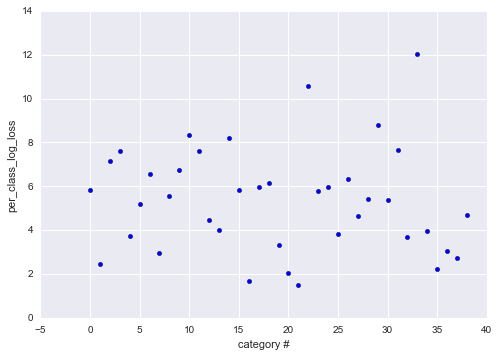

In [27]:
plt.scatter(range(0,39), per_class_log_loss)
plt.xlabel("category #")
plt.ylabel("per_class_log_loss")
plt.show()

It looks like our NB model is worst at predicting class 33 (TREA) and 22 (PORNOGRAHY/OBSCENE MAT) and is the best at predicting the most common classes 16 (LARCENY/THEFT) and 1 (ASSAULT). Classes 33 and 22 also happen to be the categories with the least amount of incidents in the training dataset. 

The next steps would be to explore how these classes are different from the other classes, and find different ways to represent these data points to make better predictions. 

We could also find summary statistics for the per-class log loss (what's the average log loss value? etc).

log loss has been a tough error metric to grasp conceptually... I'm a bit shaky on what it means to have a high or low log loss score, comparing log loss scores to each other, and so on. 

Feb 17, 2016

#### Returning a sorted list of per-class log loss

In [28]:
def sorted_perclass_logloss(labelstrs, log_losses):
    spl = []
    for i in range(len(labelstrs)):
        spl.append([labels[i], "CLASS " + str(i), log_losses[i]])
    spl = sorted(spl, key=lambda x: x[2]) # sort by the class' log loss value (the 2nd element in the list within)
    return spl

def n_highest_perclass_logloss(spl, n=39):
    # if no n is specified, this function returns the entire list sorted from highest to lowest perclass logloss
    reversed_spl = list(reversed(spl))
    return reversed_spl[0:n]

def n_lowest_perclass_logloss(spl, n=39):
    # if no n is specified, this function returns the entire list sorted from lowest to highest perclass logloss
    # spl is already in order from lowest to highest perclass logloss value
    return spl[0:n]

In [29]:
labels = sfp.decode_Y(sgd.classes_)
spl = sorted_perclass_logloss(labels, per_class_log_loss)

#### Classes with the largest perclass logloss values

These are the classes which the model has been doing the (relative) worst on classifying correctly.

In [30]:
pp.pprint(n_highest_perclass_logloss(spl, 5))

[['TREA', 'CLASS 33', 12.027566074836754],
 ['PORNOGRAPHY/OBSCENE MAT', 'CLASS 22', 10.564663378835666],
 ['SEX OFFENSES NON FORCIBLE', 'CLASS 29', 8.7778326570146277],
 ['EXTORTION', 'CLASS 10', 8.3357561451932707],
 ['GAMBLING', 'CLASS 14', 8.2043306236249816]]


#### Classes with the lowest perclass logloss values

These are the classes which the model has been doing the (relative) best at classifying corectly.

In [31]:
pp.pprint(n_lowest_perclass_logloss(spl, 5))

[['OTHER OFFENSES', 'CLASS 21', 1.5060010285177039],
 ['LARCENY/THEFT', 'CLASS 16', 1.6921075256769256],
 ['NON-CRIMINAL', 'CLASS 20', 2.0423315871700343],
 ['VANDALISM', 'CLASS 35', 2.2105913751464552],
 ['ASSAULT', 'CLASS 1', 2.4677249403370842]]


### k-fold cross validation

As an alternative validation method to the single test train split we did earlier in the notebook... As a first step I'd like to implement the k-fold cross-validation with a SGD classifier, make predictions on the data in test.csv, and submit to kaggle to compare the results from when we did the single test train split.

Warning: This is going back to an earlier stage in the predictive modelling pipeline; please don't mix up the variables after this cell with the work done above!

For every fold, a model is trained using k-1 of the folds as training data. This model is then validated on the one fold that was not used for training. The log loss of the model is an average of the log losses for all the folds. This way we don't need to reserve a validation set and suffer the consequences of having datasets with relatively few incidents to train on.

We can compare the cross validation scores between different classifiers (SGD, Random Forest, Decision Tree, Naive Bayes, etc) and get more metrics on how the models are performing. These metrics will then inform us to pick a model with which to fit the entire dataset (and then apply this model to the test.csv dataset).

[The responses to this stackoverflow post](http://stackoverflow.com/questions/32700797/saving-a-cross-validation-trained-model-in-scikit) helped clarify what role cross validation has in the process (you do cross validation when trying out models and then train the classifier using the entire training dataset if it has nice results during cross validation).

#### k fold cross validation for the models we tried earlier in this notebook

The intent here is for k fold cross validation to help us observe the effects of hyperparameters and compare performance between models trained with the same X. 

In [32]:
# instantiating sfp, X, and y again
sfp = SFP(train)
X = sfp.concat_features()
y = sfp.encode_Y(train.Category)
X.rename(columns = {'Dates':'Hour'}, inplace = True)

In [33]:
# relevant cross validation parameters
k = 5 # number of folds for k fold cross validation

In [34]:
# helper function for running cross_val_score and printing results
def cvs(clf, desired_k):
    # cvs is an abbreviation for cross validation score
    scores = cross_validation.cross_val_score(clf, X, y, scoring="log_loss", cv=desired_k)
    print("(k fold cross validation) log loss: %0.2f (+/- %0.2f)" % (-1 * scores.mean(), scores.std() * 2))
    return

Occasional issue with the classifiers that came up while prototyping this code with `cv = 10`: 
Sometimes the folds don't have incidents from all 39 classes; wondering if there's some way to guarantee this. I know that test_train_split has a some stratification parameter, but this doesn't seem to be the case with cross_val_score. :l

To explain the `-1 * scores.mean()` in the cvs function's print statement: 
The log loss returned by cross_val_score is negative... this is a notation thing with sk learn. Apparently with the sk learn scoring API, the score thata is returned is negated when it is a score that should be minimized (this is the case with log loss) and left positive if it is a score that should be mximized. The actual log loss is the positive version of this number. [Thanks to this stackoverflow post for clarifying; this particular question is about MSE but the same issue came up with negative values being returned.](https://stackoverflow.com/questions/21443865/scikit-learn-cross-validation-negative-values-with-mean-squared-error)

Note: 
The baseline model we made isn't included in the cells below; if desired we can try making a clf wrapper for it to feed into cross_val_score.


#### Decision Tree

In [35]:
clf = tree.DecisionTreeClassifier()
cvs(clf, k)

(k fold cross validation) log loss: 2.95 (+/- 0.05)


#### Random Forest

In [36]:
clf = RandomForestClassifier(random_state=1, n_estimators=10, min_samples_split=4, min_samples_leaf=1) 
cvs(clf, k)

(k fold cross validation) log loss: 2.95 (+/- 0.05)


#### Stochastic Gradient Descent

In [37]:
clf = SGDClassifier(loss="log", penalty="l2")
cvs(clf, k)

(k fold cross validation) log loss: 2.76 (+/- 0.08)


#### Naive Bayes

In [38]:
clf = BernoulliNB()
cvs(clf, k)

(k fold cross validation) log loss: 2.61 (+/- 0.02)


Overall, the trend in the k fold cross validation log loss values between these different classifiers matched the trend we saw with the simple 40/60 test train split. Naive Bayes is still in the lead, with SGD performing only slightly worse. The Decision Tree and Random Forest models had the same log loss value. 

### Next Steps?

#### Doing some more feature engineering; comparing the performance of the model with different feature combinations
* Especially to help the classes with the highest perclass logloss values

#### Visualizing the performance of our models

Ideas! (some of these can build from the work done earlier in this notebook)
* Plot the log loss values of different classifiers
* Compare training performance vs. kaggle performance
* Compare classifiers with different hyperparameter values used
* Summary statistics
* Making a confusion matrix. [See the example on the sk learn website.](http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html)

Still kind of fuzzy on the log_loss metric as a means of understanding the accuracy of our model. Our baseline was developed under the assumption that all crimes are actual "LACENCY/THEFT" and our score was shown above to be around 27.65.  

Focus on the "focus of impact" aspect of project. Goal of reccommending districts where the plice forces can redistribute their forces. This may include certain map vizualizations of the districts and time. For a specific time (day or hour) suggest what crime and what location (district) it may occur.

Look at the effect of a given crime at a district. --> Potentially descriptive provision of solution (training, preparation etc.) that is going to be more exploratory. Consider different facets of training that a PD district can take into account. 

### Ensemble Example

In [39]:
# todo

### A new baseline

In [40]:
from sklearn.linear_model import LogisticRegression
import numpy as np

# Apply a new baseline model with logistic regression that contains no features
new_baseline_model = LogisticRegression(multi_class='multinomial', solver='newton-cg')

# Fit the data to the model
new_baseline_model.fit(np.ones((X_train.shape[0],1)), y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=1, penalty='l2', random_state=None, solver='newton-cg',
          tol=0.0001, verbose=0, warm_start=False)

In [41]:
y_predictions = new_baseline_model.predict_proba(np.zeros((X_test.shape[0],1)))

baseline_per_class_log_loss = compute_per_class_log_loss(y_predictions, y_test)
baseline_aggregate_log_loss = log_loss(y_test, y_predictions)
print "Our baseline aggregate log loss is ", baseline_aggregate_log_loss

Our baseline aggregate log loss is  2.68000308005


In [42]:
labels = sfp.decode_Y(new_baseline_model.classes_)
spl_base = sorted_perclass_logloss(labels, baseline_per_class_log_loss)

In [43]:
pp.pprint(n_highest_perclass_logloss(spl_base, 5))

[['TREA', 'CLASS 33', 12.075908716812071],
 ['PORNOGRAPHY/OBSCENE MAT', 'CLASS 22', 10.46637346282898],
 ['GAMBLING', 'CLASS 14', 8.6845870878933571],
 ['SEX OFFENSES NON FORCIBLE', 'CLASS 29', 8.651464898144928],
 ['EXTORTION', 'CLASS 10', 8.0605792890613301]]


In [44]:
pp.pprint(n_lowest_perclass_logloss(spl_base, 5))

[['LARCENY/THEFT', 'CLASS 16', 1.3363669221467298],
 ['OTHER OFFENSES', 'CLASS 21', 1.6832714085173539],
 ['NON-CRIMINAL', 'CLASS 20', 2.0268515268952094],
 ['ASSAULT', 'CLASS 1', 2.2299783532184332],
 ['DRUG/NARCOTIC', 'CLASS 7', 2.6240661779641616]]


## Plot sorted baseline log_losses 

([<matplotlib.axis.XTick at 0x11b422390>,
 <a list of 39 Text xticklabel objects>)

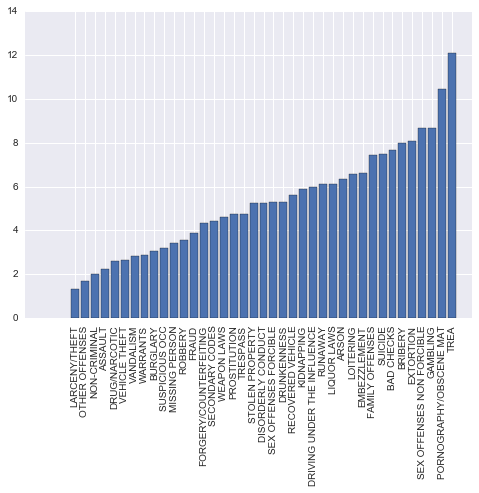

In [45]:
import matplotlib.pyplot as plt
import numpy as np

sorted_crimes = n_lowest_perclass_logloss(spl_base)
y_values = []
x_values = []

for i in range(len(sorted_crimes)):
    y_values.append(sorted_crimes[i][2])
    x_values.append(sorted_crimes[i][0])
    
plt.bar(range(len(sorted_crimes)), y_values, align='center')
plt.xticks(range(len(sorted_crimes)), x_values, rotation='vertical')


After we plotted the log_loss values for our baseline it is time to compare our perclass log_loss of our baseline with one of our models, as shown below.

## Thoughts
SFP.prep_hours() API method --> potentially handle "bin" input for get_dummies option based on Paul comment on making binarized 